In [488]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [489]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [490]:
loaded = False

# Load BioBank Components

In [ ]:
DEV_MODE = False
SIGNIFIER = ""

if not loaded:
    biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE, signifier=SIGNIFIER)
    loaded = True

Importing BioBank Index and Data:
Missing 0 biobank index names
Reduced feature set has 369 features.
UK BioBank Data Loaded.
Size: 502536 rows x 369 columns
Elapsed time: 68.0856 seconds


Mapping Medical Codes:  13%|█▎        | 45/354 [00:11<01:55,  2.68 feature/s]

In [144]:
hla_alleles = data_tools.load_hla_data()

biobank_data = biobank_data.merge(hla_alleles, how="left", on="eid")

# Constants

In [145]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

# Viral Codes

In [483]:
mononucleosis_code = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
hiv_code = 'hiv/aids'
herpes_simplex_code = "herpes simplex"
hepatitis_code = "infective/viral hepatitis"

data_tools.biobank_search(med_code_mapping, biobank_data, ("clovir"))

,coding,meaning,code_format,name,count
2865,1140874370,aciclovir,4,treatment_code,380
4451,1140909954,acyclovir,4,treatment_code,146
4722,1140916890,valaciclovir,4,treatment_code,4
1286,1140864424,famciclovir,4,treatment_code,3
6300,1141186288,clearsore aciclovir 5% cream,4,treatment_code,3
2889,1140874472,ganciclovir,4,treatment_code,0
4944,1140926522,penciclovir,4,treatment_code,0
5382,1141157268,ganciclovir product,4,treatment_code,0
5383,1141157270,famciclovir product,4,treatment_code,0
5384,1141157272,valaciclovir product,4,treatment_code,0


 # Exploring ICD 10 Cancer Types

In [148]:
ICD10_data = biobank_data.loc[~biobank_data["cancer_type_ICD10"].isna()].copy(deep=True)

In [149]:
display(data_tools.biobank_search(med_code_mapping, biobank_data, ("C82")).query("name == 'cancer_type_ICD10'"))
display(data_tools.biobank_search(med_code_mapping, biobank_data,
                                  ("non-hodg")).query("name == 'cancer_type_ICD10' and count != 0"))

,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1631,C821,C82.1 Mixed small cleaved and large cell; foll...,19,cancer_type_ICD10,77
1630,C820,C82.0 Small cleaved cell; follicular,19,cancer_type_ICD10,41
1632,C822,C82.2 Large cell; follicular,19,cancer_type_ICD10,40
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1629,C82,C82 Follicular [nodular] non-Hodgkin's lymphoma,19,cancer_type_ICD10,0
1633,C823,C82.3 Follicular lymphoma grade IIIa,19,cancer_type_ICD10,0
1634,C824,C82.4 Follicular lymphoma grade IIIb,19,cancer_type_ICD10,0
1635,C825,C82.5 Diffuse follicle centre lymphoma,19,cancer_type_ICD10,0
1636,C826,C82.6 Cutaneous follicle centre lymphoma,19,cancer_type_ICD10,0


,coding,meaning,code_format,name,count
1638,C829,C82.9 Follicular non-Hodgkin's lymphoma; unspe...,19,cancer_type_ICD10,301
1666,C859,C85.9 Non-Hodgkin's lymphoma; unspecified type,19,cancer_type_ICD10,237
1648,C838,C83.8 Other types of diffuse non-Hodgkin's lym...,19,cancer_type_ICD10,117
1665,C857,C85.7 Other specified types of non-Hodgkin's l...,19,cancer_type_ICD10,115
1637,C827,C82.7 Other types of follicular non-Hodgkin's ...,19,cancer_type_ICD10,23
1649,C839,C83.9 Diffuse non-Hodgkin's lymphoma; unspecified,19,cancer_type_ICD10,14


In [305]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7125417/
viral_associated_cancers = ["hodgkin's lymphoma", "gastric carcinoma", "burkitt's lymphoma", "nasopharyngeal carcinoma"]
ICD10_viral_associated_cancer_labels = {
    "burkitt's lymphoma": ["C83.7"],
    "nasopharyngeal carcinoma": ["C11"],
    "gastric carcinoma": ["C16", "D37.1"],
    "hodgkin's disease": ["C81.9", "C81.7"],
    "kaposi's sarcoma": ["C46"],
#     "liver cancer": ["C22"],
#     "anal cancer": ["C21"],
#     "non-hodgkin's lymphoma": ["C82.9", "C82.7", "C83.8", "C85.7", "C83.9"]
}

viral_labels = {
    "mononucleosis_code": 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)',
    "hiv_code": 'hiv/aids',
    "herpes_simplex_code": "herpes simplex",
    "hepatitis_code": "infective/viral hepatitis"
}

antiviral_labels = {"acyclovir": "clovir"}

ICD10_viral_associated_cancer_labels

{"burkitt's lymphoma": ['C83.7'],
 'nasopharyngeal carcinoma': ['C11'],
 'gastric carcinoma': ['C16', 'D37.1'],
 "hodgkin's disease": ['C81.9', 'C81.7'],
 "kaposi's sarcoma": ['C46']}

In [306]:
def apply_grouping(variable_tag: str, grouping: dict, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping.items():
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

def apply_tuple_grouping(variable_tag: str, grouping: tuple, default: str = None) -> str:
    """"""
    if isinstance(variable_tag, float):
        return default
    
    for label, tag_set in grouping:
        if isinstance(tag_set, str):
            if tag_set in variable_tag:
                return label
            continue

        for tag in tag_set:
            if tag in variable_tag:
                return label

    return default

# def multicolumn_apply_grouping() 

In [307]:
base_feature = "illness_code"
params = dict(grouping=[(True, "infective/viral hepatitis"), (True, "hepatitis a")], default=False)

features = [feature for feature in ICD10_data.columns if feature.startswith(base_feature + "_0")]
aggregated_feature_values = ICD10_data[features[0]].apply(apply_tuple_grouping, **params)

for feature in features[1:]:
    found_values = ICD10_data[feature].apply(apply_tuple_grouping, **params)
    aggregated_feature_values = aggregated_feature_values | found_values
    
ICD10_data["infective/viral hepatitis"] = aggregated_feature_values * 1

In [308]:
ICD10_data["viral_infection"] = ICD10_data["illness_code"].apply(apply_grouping, grouping=viral_labels,
                                                                 default="no viral illness")
ICD10_data["given_antiviral"] = ICD10_data["treatment_code"].apply(apply_grouping, grouping=antiviral_labels,
                                                                 default="no antiviral")

In [367]:
ICD10_data["virus_associated_cancer"] = ICD10_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

biobank_data["virus_associated_cancer"] = biobank_data["cancer_type_ICD10"].apply(apply_grouping, 
                                                                              grouping=ICD10_viral_associated_cancer_labels,
                                                                              default="non-virus associated")

In [373]:
biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"

<ipython-input-373-9a5cdfa039cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biobank_data["virus_associated_cancer"].loc[biobank_data["cancer_type_ICD10"].isna()] = "no cancer"


# Viral Associated Summary Statistics

In [406]:
variables_of_interest = ["sex"]
grouping = ["virus_associated_cancer"]
extra = ["homozygosity"]

grouping_df = biobank_data[grouping + variables_of_interest + extra].copy(deep=True)
grouping_df["total"] = grouping_df[variables_of_interest[0]] != "nothing"

for variable in variables_of_interest:
    for variable_option in sorted(grouping_df[variable].unique()):
        grouping_df[variable_option.lower().replace(" ", "_")] = grouping_df[variable] == variable_option

grouping_df = grouping_df.groupby(grouping).sum().reset_index()

# for variable in exclude(grouping_df.columns, grouping + ["total"]):
#     grouping_df[variable + "_fraction"] = grouping_df[variable] / grouping_df["total"]

grouping_df = grouping_df.sort_values("total", ascending=False)
grouping_df["homozygosity"] /= grouping_df["total"]
grouping_df = grouping_df.rename({"homozygosity": "mean_hla_homozygosity"}, axis=1)
display(grouping_df)

,virus_associated_cancer,mean_hla_homozygosity,total,female,male
5,no cancer,0.314676,419053,227161,191892
6,non-virus associated,0.324864,82813,46015,36798
1,gastric carcinoma,0.316929,508,166,342
2,hodgkin's disease,0.400000,90,42,48
4,nasopharyngeal carcinoma,0.187500,32,14,18
0,burkitt's lymphoma,0.400000,25,4,21
3,kaposi's sarcoma,0.066667,15,0,15


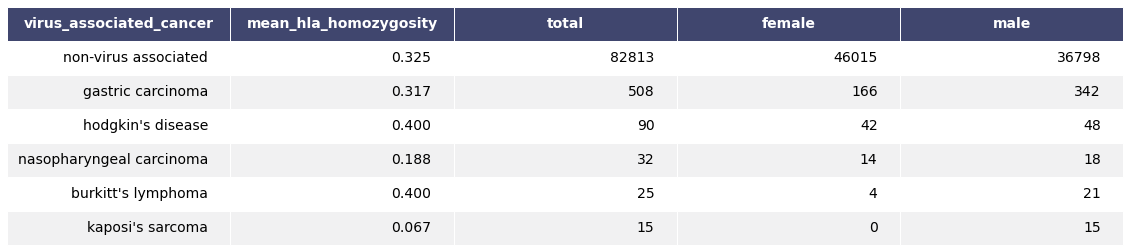

In [411]:
data = grouping_df.copy(deep=True)
data["mean_hla_homozygosity"] = data["mean_hla_homozygosity"].apply(lambda s: f"{s:.3f}")
fig, ax = render_mpl_table(data, header_columns=0, col_width=4.0)
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary_table.png")
grouping_df = grouping_df.loc[~ grouping_df["virus_associated_cancer"].isin(["no cancer", "non-virus associated"])]

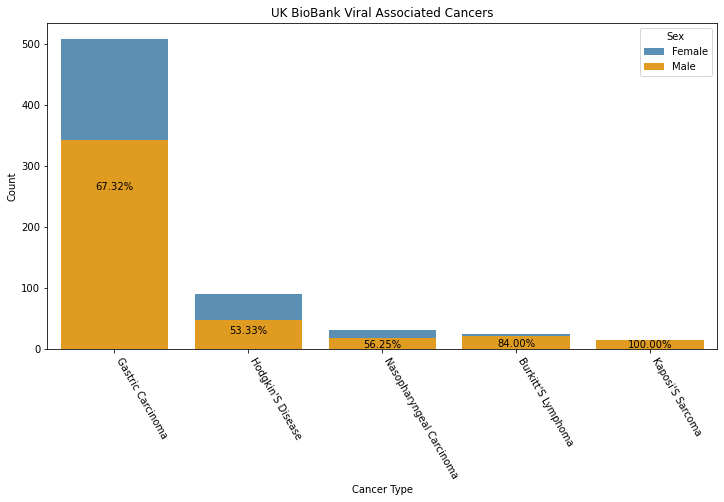

In [412]:
data = grouping_df
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=data, x="virus_associated_cancer", y="total", color="C0", alpha=.8, label="Female")
sns.barplot(data=data, x="virus_associated_cancer", y="male", color="orange", alpha=1, label="Male")

i = 0
for y_i, frac_male in zip(data["male"], data["male"] / data["total"]):
    ax.text(i, max(y_i * .8, 15), f"{frac_male * 100:.02f}%", ha="center", va="top")
    i += 1

add_plt_labels(ax=ax, x="Cancer Type", y="Count")
ax.legend(title="Sex")
ax.set_title("UK BioBank Viral Associated Cancers")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_summary.png")

# Viral Associated Age of Diagnosis Plots 

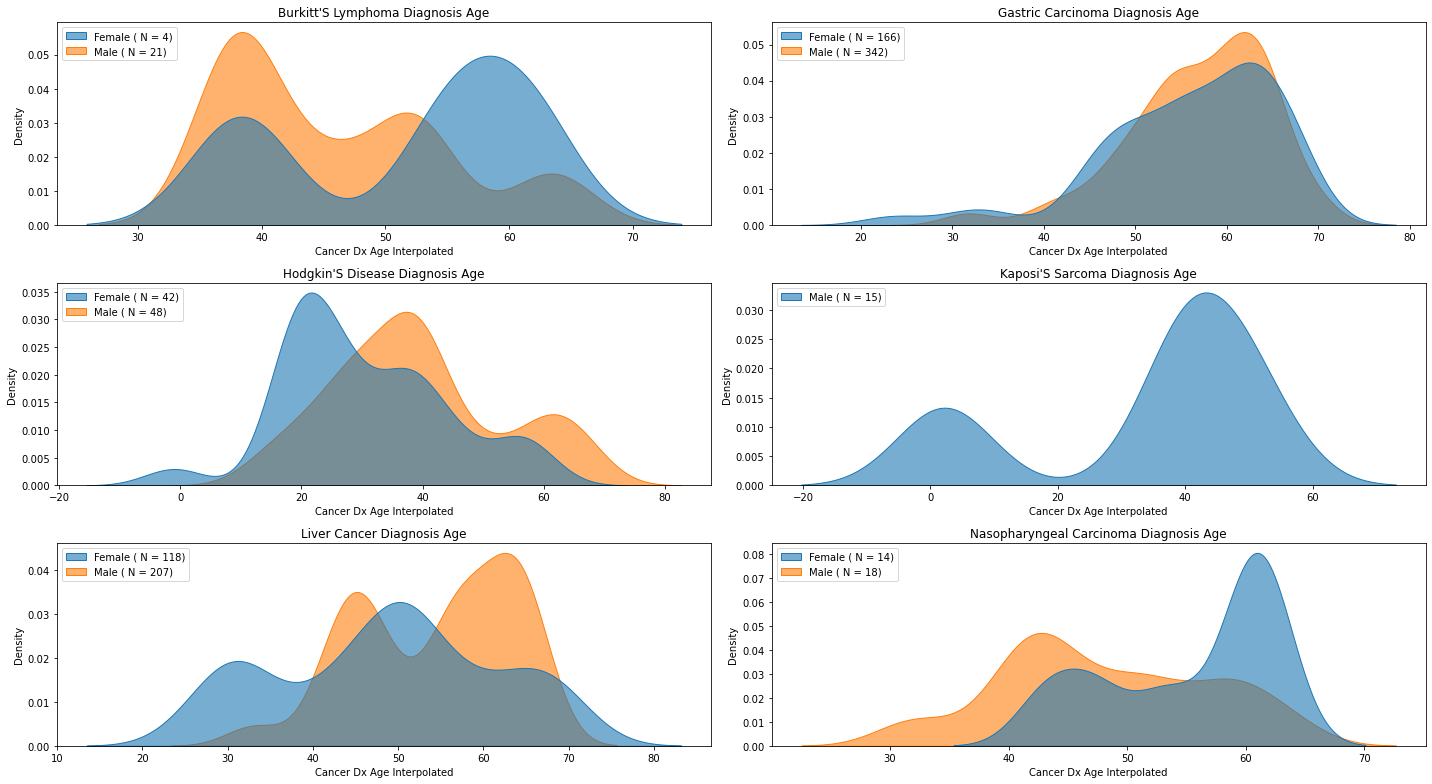

In [413]:
grouping = ICD10_data.groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "sex"

fig, axes = create_subplot(len(grouping), width=20, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer_status"]), axes):
    sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.35, common_norm=False, shade=True)
#     sns.histplot(data=subset, x=x, hue=hue, ax=ax, multiple="dodge", alpha=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_type.title()} Diagnosis Age")
    ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")

<AxesSubplot:xlabel='virus_associated_cancer', ylabel='cancer_dx_age_interpolated'>

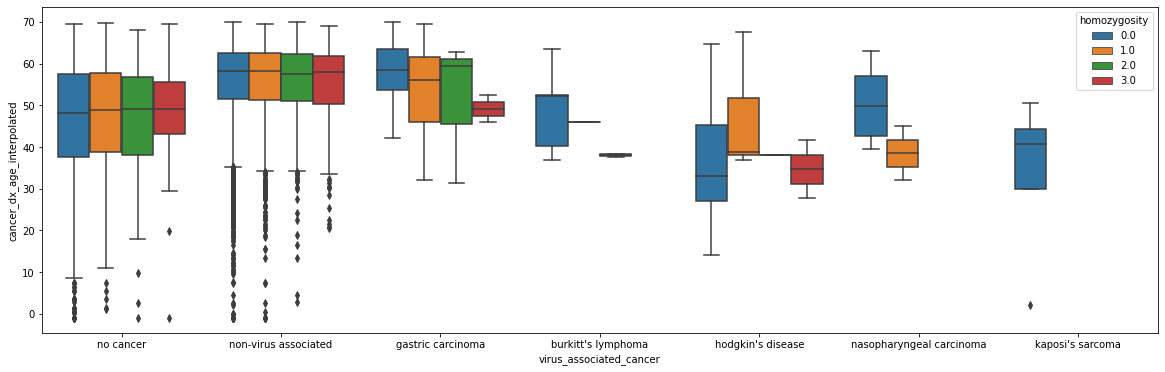

In [414]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=biobank_data.query("sex == 'Male'"), x="virus_associated_cancer", hue="homozygosity", y=x, ax=ax)
# add_plt_labels(ax, x="Number of Homozygous HLA Alleles", y=x)

<ipython-input-473-dfae96452b02>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


(-0.2, 7.4)

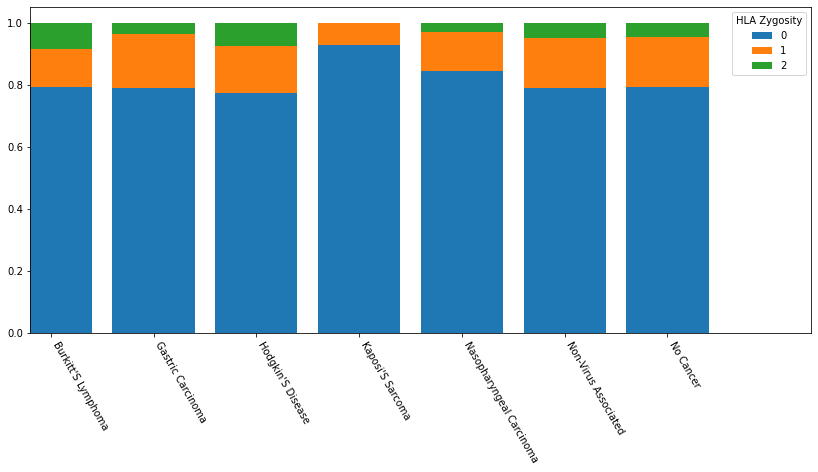

In [473]:
cancer_types = sorted(biobank_data["virus_associated_cancer"].unique())
cancer_types = [c for c in cancer_types if c != "no cancer"] + ["no cancer"]

values = []
for homozygosity in range(3):
    data = biobank_data.query(f"homozygosity == {homozygosity}")
    values.append([(data["virus_associated_cancer"] == cancer_type).sum() for cancer_type in cancer_types])
values = np.cumsum(values, axis=0)
counts = values[-1]
values = values / counts

fig, ax = plt.subplots(figsize=(14, 6))
for i, value_set in zip(range(3), values):
    ax.bar(cancer_types, value_set, label=i, zorder=- i)

ax.legend(title="HLA Zygosity")
plt.draw()
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");
ax.set_xlim(-.2, len(counts) + .4)

/Users/cole/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/cole/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


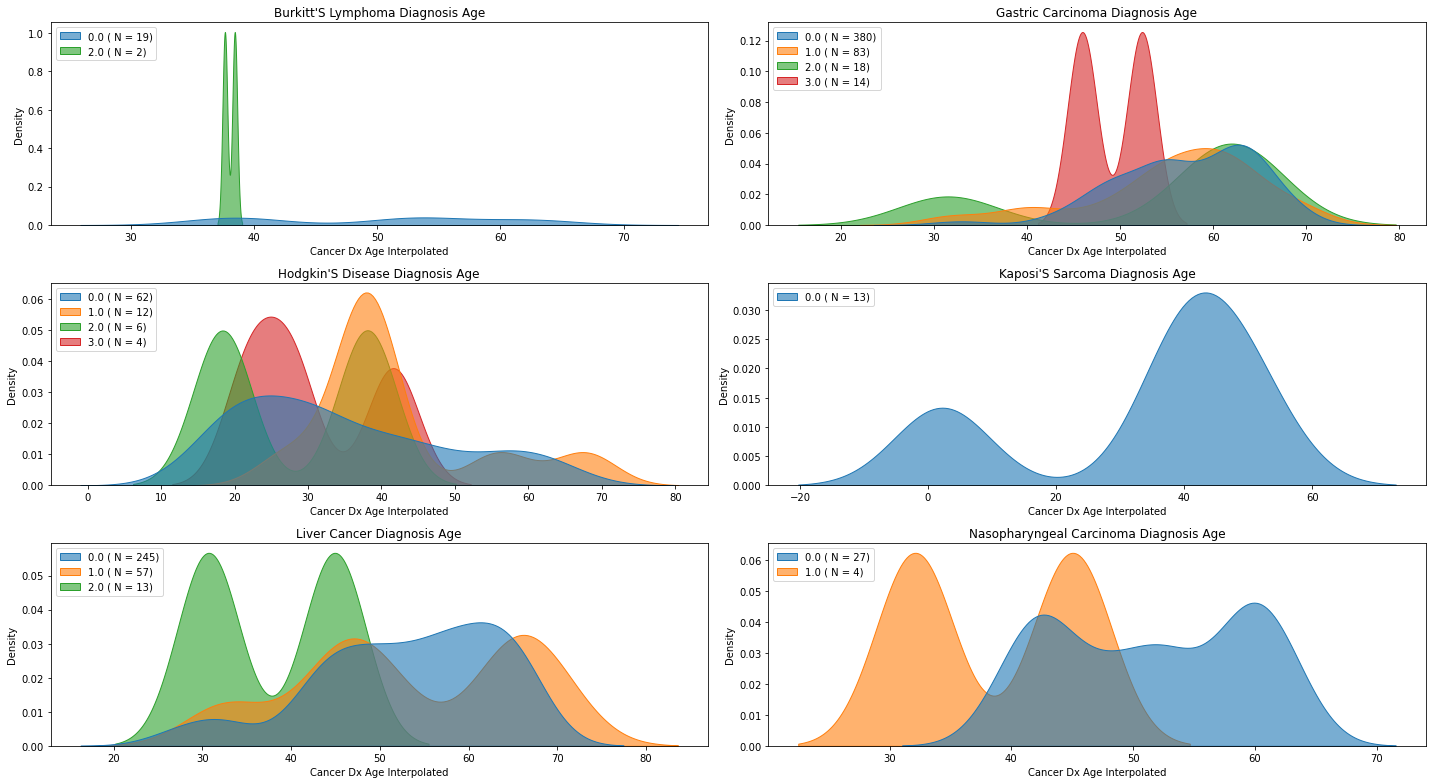

In [390]:
grouping = ICD10_data.query("sex == 'Male'").groupby(["virus_associated_cancer"])
grouping = {label: subset for label, subset in grouping}

x, y, hue = "cancer_dx_age_interpolated", "density", "homozygosity"

fig, axes = create_subplot(len(grouping), width=20, height_per=3)
for (cancer_type, subset), ax in zip(ICD10_data.groupby(["virus_associated_cancer_status"]), axes):
    sns_wrapper(sns.kdeplot, data=subset, x=x, hue=hue, ax=ax, bw_method=.35, common_norm=False, shade=True)
#     sns.histplot(data=subset, x=x, hue=hue, ax=ax, multiple="dodge", alpha=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{str(cancer_type).title()} Diagnosis Age")
    ax.legend(loc="upper left")

fig.tight_layout()
fig.savefig("cancer_ICD10_plots/viral_associated_cancer_age_dx.png")